### Required Imports

In [190]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

### Load and unpickle files from directory

In [191]:
def load_and_unpickle(class_type, directory, subdirectory):
    """
    Description:
    Loads and Unpickles a file from the supplied parameters
    
    Parameter:
    class_type (str): class type to be loaded and unpickled\n
    directory (str): directory within the CWD\n
    subdirectory (str): subdirectory within the directory specified\n
    
    Returns:
    Specified dataframe if found in the directory\n
    None if not found\n
    """
    dir_path = f"{directory}/{subdirectory}"
    filename = f'{class_type}.pkl'
    filepath = os.path.join(dir_path, filename)

    if os.path.exists(filepath):
        df = pd.read_pickle(filepath)
        print(f"Loaded from {subdirectory} for class {class_type}")
        return df
    else:
        print(f"File not found: {filepath}")
        return None

### Function to get necessary dataframes from directories

In [192]:
def get_dataframes(isClean = False):
    classes = ["Jump", "Run", "Walk", "Squat"]
    original_directory = "Original"
    clean_directory = "Clean"
    training_subdirectory = "Training"
    test_subdirectory = "Test"
    validation_subdirectory = "Validation"
    
    train_df_arr = []
    test_df_arr = []
    valid_df_arr = []
    
    complete_train_df = pd.DataFrame()
    complete_test_df = pd.DataFrame()
    complete_valid_df = pd.DataFrame()
    
    for class_type in classes:
        if(isClean):
            train_df_arr.append(load_and_unpickle(class_type, clean_directory, training_subdirectory))
            test_df_arr.append(load_and_unpickle(class_type, clean_directory, test_subdirectory))
            valid_df_arr.append(load_and_unpickle(class_type, clean_directory, validation_subdirectory))
        else:
            train_df_arr.append(load_and_unpickle(class_type, original_directory, training_subdirectory))
            test_df_arr.append(load_and_unpickle(class_type, original_directory, test_subdirectory))
            valid_df_arr.append(load_and_unpickle(class_type, original_directory, validation_subdirectory))
    
    for train_df, test_df, valid_df in zip(train_df_arr, test_df_arr, valid_df_arr):
        complete_train_df = pd.concat([complete_train_df, train_df], ignore_index=True)
        complete_test_df = pd.concat([complete_test_df, test_df], ignore_index=True)
        complete_valid_df = pd.concat([complete_valid_df, valid_df], ignore_index=True)

    return complete_train_df, complete_test_df, complete_valid_df

### Create 3 big dataframes

In [193]:
original_train_df, original_test_df, original_valid_df = get_dataframes()
clean_train_df, clean_test_df, clean_valid_df = get_dataframes(True)


Loaded from Training for class Jump
Loaded from Test for class Jump
Loaded from Validation for class Jump
Loaded from Training for class Run
Loaded from Test for class Run
Loaded from Validation for class Run
Loaded from Training for class Walk
Loaded from Test for class Walk
Loaded from Validation for class Walk
Loaded from Training for class Squat
Loaded from Test for class Squat
Loaded from Validation for class Squat
Loaded from Training for class Jump
Loaded from Test for class Jump
Loaded from Validation for class Jump
Loaded from Training for class Run
Loaded from Test for class Run
Loaded from Validation for class Run
Loaded from Training for class Walk
Loaded from Test for class Walk
Loaded from Validation for class Walk
Loaded from Training for class Squat
Loaded from Test for class Squat
Loaded from Validation for class Squat


### Create neural network

In [194]:
def create_neural_network(neurons, hidden_layers):
    model = Sequential()
    # Input layer with 6 features and a hidden layer with 10 neurons
    model.add(Dense(neurons, input_dim=6, activation='relu', name="Hidden_Layer_1"))
    for i in range(1, hidden_layers): 
        # Hidden layer with 10 neurons
        model.add(Dense(neurons, activation="relu", name=f"Hidden_Layer_{i+1}"))

    # Output layer with 4 outputs
    model.add(Dense(4, activation="softmax", name="Output_Layer"))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Train Model

In [195]:
def train_model(train_df, valid_df, neurons, hidden_layers, batch_size=32, epochs=50, normalized=False):
    
    label_encoder = LabelEncoder()
    
    X_train = train_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']]  # Feature columns
    Y_train = train_df['Class']  # Label column
    X_val = valid_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']]  # Feature columns
    Y_val = valid_df['Class']  # Label column
    
    model = create_neural_network(neurons= neurons, hidden_layers= hidden_layers)
    Y_train_encoded = label_encoder.fit_transform(Y_train)
    Y_val_encoded = label_encoder.transform(Y_val)
    
    if normalized:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
    
    history = model.fit(
        x= X_train,
        y= Y_train_encoded,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, Y_val_encoded)
    )
    
    return model, history, label_encoder
    

### Plot Accuracy/Loss

In [196]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()
    plt.show()

### Evaluate Model

In [197]:
def evaluate_model(test_df, model, label_encoder, normalize=False):
    # Feature columns and label column
    X_test = test_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']]
    Y_test = test_df['Class']

    # Normalize test data if normalization was applied during training
    if normalize:
        scaler = MinMaxScaler()
        X_test = scaler.fit_transform(X_test)

    # Encode the test labels using the label_encoder from training
    Y_test_encoded = label_encoder.transform(Y_test)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded, verbose=1)

    return test_loss, test_accuracy


### Plot Confusion Matrix

In [198]:
def plot_confusion_matrix(test_df, model, label_encoder, normalize=False):
    X_test = test_df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']]
    Y_test = test_df['Class']
    
    if normalize:
        scaler = MinMaxScaler()
        X_test = scaler.fit_transform(X_test)
    
    Y_pred_prob = model.predict(X_test)
    Y_pred_encoded = np.argmax(Y_pred_prob, axis=1)
    
    Y_pred = label_encoder.inverse_transform(Y_pred_encoded)
    
    cm = confusion_matrix(Y_test, Y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=label_encoder.classes_,  # Use original class names for axis
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Unnormalized Data

### Original Data, 10 Neurons per Layer, Unnormalized

In [199]:
model_10_original, history_10_original, label_encoder_10_original = train_model(
    train_df=original_train_df,
    valid_df=original_valid_df,
    neurons=10,
    hidden_layers=2
)

Epoch 1/50
567/567 [==============================] - 2s 3ms/step - loss: 1.1692 - accuracy: 0.4916 - val_loss: 1.3587 - val_accuracy: 0.4154
Epoch 2/50
567/567 [==============================] - 1s 2ms/step - loss: 0.9133 - accuracy: 0.6208 - val_loss: 1.6249 - val_accuracy: 0.4574
Epoch 3/50
567/567 [==============================] - 1s 2ms/step - loss: 0.8200 - accuracy: 0.6753 - val_loss: 1.6036 - val_accuracy: 0.4695
Epoch 4/50
567/567 [==============================] - 1s 2ms/step - loss: 0.7632 - accuracy: 0.7030 - val_loss: 1.5356 - val_accuracy: 0.4781
Epoch 5/50
567/567 [==============================] - 1s 2ms/step - loss: 0.7221 - accuracy: 0.7210 - val_loss: 1.6005 - val_accuracy: 0.4921
Epoch 6/50
567/567 [==============================] - 1s 2ms/step - loss: 0.6883 - accuracy: 0.7360 - val_loss: 1.5873 - val_accuracy: 0.5093
Epoch 7/50
567/567 [==============================] - 1s 2ms/step - loss: 0.6618 - accuracy: 0.7454 - val_loss: 1.5330 - val_accuracy: 0.5232
Epoch 

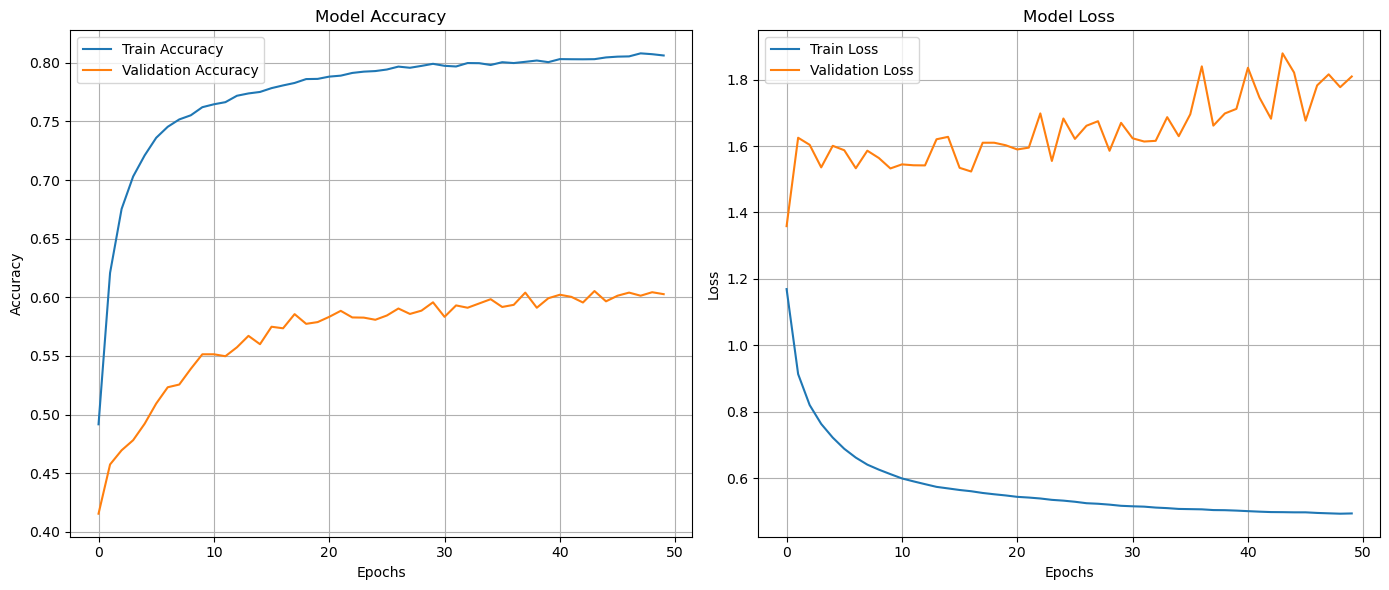

In [200]:
plot_training_history(history_10_original)

In [201]:
original_10_test_loss, original_10_test_accuracy = evaluate_model(
    test_df=original_test_df,
    model=model_10_original,
    label_encoder=label_encoder_10_original
)

print(f"Test Loss: {original_10_test_loss:.4f}")
print(f"Test Accuracy: {original_10_test_accuracy:.4f}")

189/189 [==============================] - 0s 2ms/step - loss: 0.5542 - accuracy: 0.7701
Test Loss: 0.5542
Test Accuracy: 0.7701


189/189 [==============================] - 0s 1ms/step


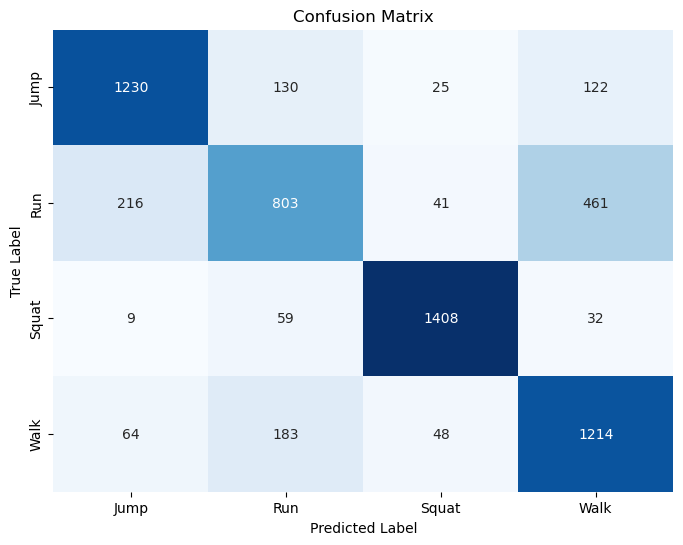

In [202]:
plot_confusion_matrix(
    test_df=original_test_df,
    model=model_10_original,
    label_encoder=label_encoder_10_original
)

### Original Data, 50 Neurons per Layer, Unnormalized

In [203]:
model_50_original, history_50_original, label_encoder_50_original = train_model(
    train_df=original_train_df,
    valid_df=original_valid_df,
    neurons=50,
    hidden_layers=2
)

Epoch 1/50
567/567 [==============================] - 2s 3ms/step - loss: 0.8973 - accuracy: 0.6296 - val_loss: 1.5750 - val_accuracy: 0.5310
Epoch 2/50
567/567 [==============================] - 1s 2ms/step - loss: 0.6093 - accuracy: 0.7685 - val_loss: 1.5511 - val_accuracy: 0.5919
Epoch 3/50
567/567 [==============================] - 1s 3ms/step - loss: 0.5153 - accuracy: 0.8059 - val_loss: 1.7479 - val_accuracy: 0.5846
Epoch 4/50
567/567 [==============================] - 1s 3ms/step - loss: 0.4739 - accuracy: 0.8196 - val_loss: 1.7932 - val_accuracy: 0.5959
Epoch 5/50
567/567 [==============================] - 1s 3ms/step - loss: 0.4469 - accuracy: 0.8308 - val_loss: 1.9056 - val_accuracy: 0.5886
Epoch 6/50
567/567 [==============================] - 1s 3ms/step - loss: 0.4281 - accuracy: 0.8380 - val_loss: 1.9614 - val_accuracy: 0.6036
Epoch 7/50
567/567 [==============================] - 1s 3ms/step - loss: 0.4119 - accuracy: 0.8470 - val_loss: 1.9928 - val_accuracy: 0.6380
Epoch 

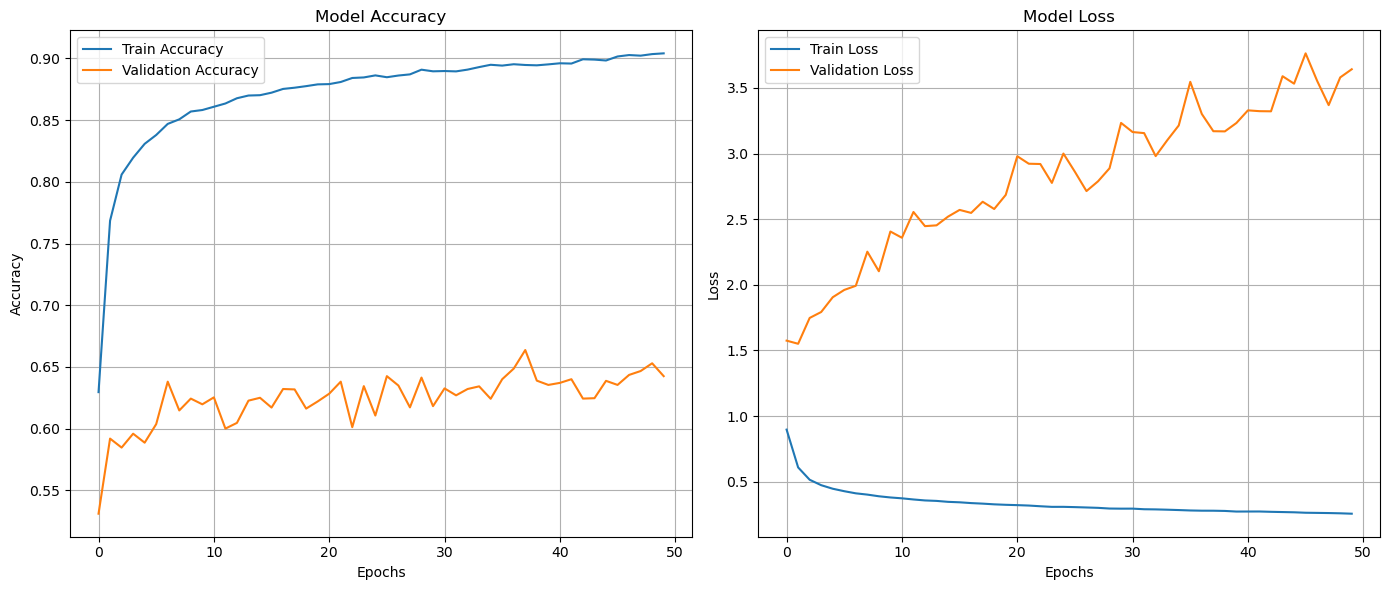

In [204]:
plot_training_history(history_50_original)

In [205]:
original_50_test_loss, original_50_test_accuracy = evaluate_model(
    test_df=original_test_df,
    model=model_50_original,
    label_encoder=label_encoder_50_original
)

print(f"Test Loss: {original_50_test_loss:.4f}")
print(f"Test Accuracy: {original_50_test_accuracy:.4f}")

189/189 [==============================] - 0s 2ms/step - loss: 0.5135 - accuracy: 0.8071
Test Loss: 0.5135
Test Accuracy: 0.8071


189/189 [==============================] - 0s 1ms/step


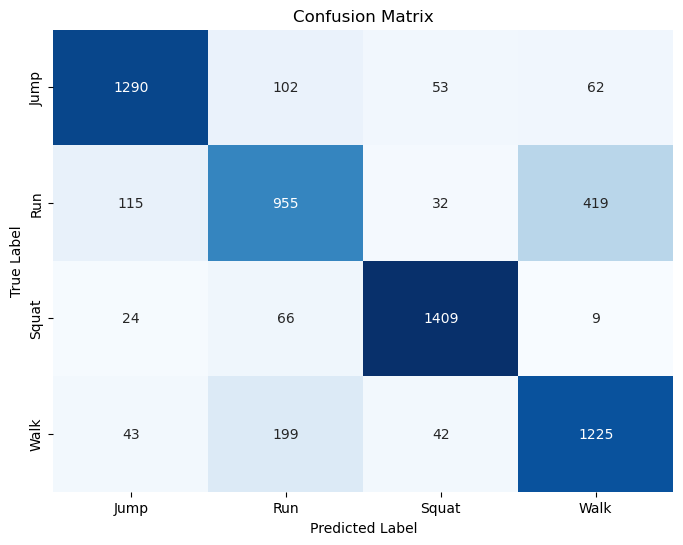

In [206]:
plot_confusion_matrix(
    test_df=original_test_df,
    model=model_50_original,
    label_encoder=label_encoder_50_original
)

### Clean Data, 10 Neurons per Layer, Unnormalized

In [207]:
model_10_clean, history_10_clean, label_encoder_10_clean = train_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=10,
    hidden_layers=2
)

Epoch 1/50
492/492 [==============================] - 2s 3ms/step - loss: 1.2852 - accuracy: 0.4531 - val_loss: 1.2547 - val_accuracy: 0.4223
Epoch 2/50
492/492 [==============================] - 1s 3ms/step - loss: 0.9577 - accuracy: 0.6018 - val_loss: 1.5475 - val_accuracy: 0.4416
Epoch 3/50
492/492 [==============================] - 1s 3ms/step - loss: 0.7950 - accuracy: 0.6937 - val_loss: 1.5336 - val_accuracy: 0.5098
Epoch 4/50
492/492 [==============================] - 1s 3ms/step - loss: 0.7144 - accuracy: 0.7279 - val_loss: 1.5018 - val_accuracy: 0.5272
Epoch 5/50
492/492 [==============================] - 1s 3ms/step - loss: 0.6678 - accuracy: 0.7448 - val_loss: 1.4557 - val_accuracy: 0.5373
Epoch 6/50
492/492 [==============================] - 1s 3ms/step - loss: 0.6311 - accuracy: 0.7594 - val_loss: 1.4414 - val_accuracy: 0.5670
Epoch 7/50
492/492 [==============================] - 1s 2ms/step - loss: 0.6022 - accuracy: 0.7703 - val_loss: 1.5069 - val_accuracy: 0.5516
Epoch 

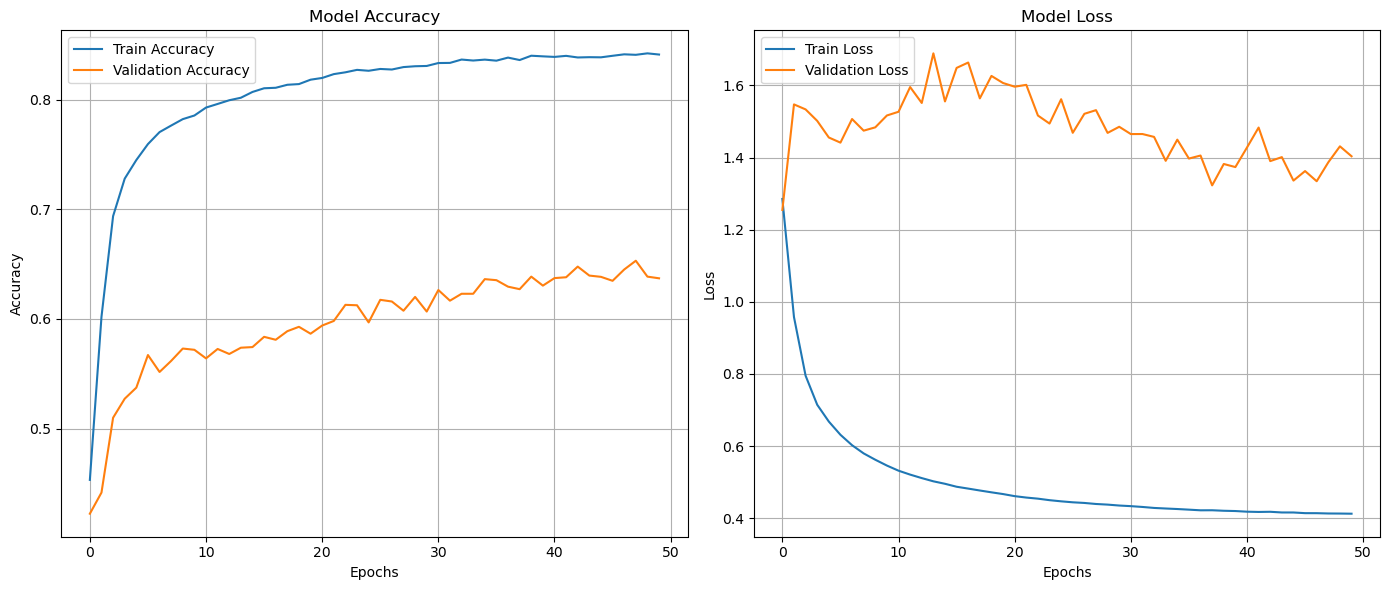

In [208]:
plot_training_history(history_10_clean)

In [209]:
clean_10_test_loss, clean_10_test_accuracy = evaluate_model(
    test_df=clean_test_df,
    model=model_10_clean,
    label_encoder=label_encoder_10_clean
)

print(f"Test Loss: {clean_10_test_loss:.4f}")
print(f"Test Accuracy: {clean_10_test_accuracy:.4f}")

164/164 [==============================] - 0s 2ms/step - loss: 0.4891 - accuracy: 0.8097
Test Loss: 0.4891
Test Accuracy: 0.8097


164/164 [==============================] - 0s 2ms/step


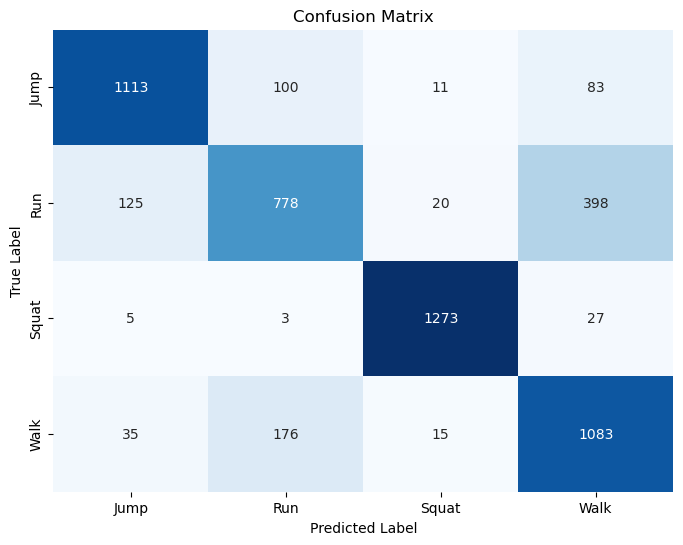

In [210]:
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_10_clean,
    label_encoder=label_encoder_10_clean
)

### Clean Data, 50 Neurons per Layer, Unnormalized

In [211]:
model_50_clean, history_50_clean, label_encoder_50_clean = train_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=50,
    hidden_layers=2
)

Epoch 1/50
492/492 [==============================] - 2s 3ms/step - loss: 0.8816 - accuracy: 0.6374 - val_loss: 1.4975 - val_accuracy: 0.5584
Epoch 2/50
492/492 [==============================] - 1s 2ms/step - loss: 0.5744 - accuracy: 0.7884 - val_loss: 1.6516 - val_accuracy: 0.5765
Epoch 3/50
492/492 [==============================] - 1s 2ms/step - loss: 0.4751 - accuracy: 0.8197 - val_loss: 1.6358 - val_accuracy: 0.6183
Epoch 4/50
492/492 [==============================] - 1s 2ms/step - loss: 0.4221 - accuracy: 0.8412 - val_loss: 1.8324 - val_accuracy: 0.6164
Epoch 5/50
492/492 [==============================] - 1s 2ms/step - loss: 0.3884 - accuracy: 0.8532 - val_loss: 1.7387 - val_accuracy: 0.6158
Epoch 6/50
492/492 [==============================] - 1s 3ms/step - loss: 0.3642 - accuracy: 0.8623 - val_loss: 1.8646 - val_accuracy: 0.6376
Epoch 7/50
492/492 [==============================] - 1s 3ms/step - loss: 0.3429 - accuracy: 0.8728 - val_loss: 1.7446 - val_accuracy: 0.6355
Epoch 

In [212]:
clean_50_test_loss, clean_50_test_accuracy = evaluate_model(
    test_df=clean_test_df,
    model=model_50_clean,
    label_encoder=label_encoder_50_clean
)

print(f"Test Loss: {clean_50_test_loss:.4f}")
print(f"Test Accuracy: {clean_50_test_accuracy:.4f}")

164/164 [==============================] - 0s 2ms/step - loss: 0.4626 - accuracy: 0.8334
Test Loss: 0.4626
Test Accuracy: 0.8334


164/164 [==============================] - 0s 1ms/step


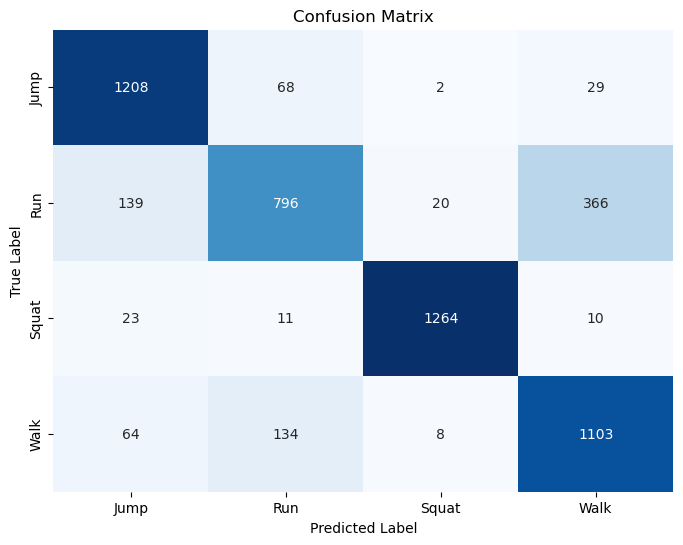

In [213]:
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_50_clean,
    label_encoder=label_encoder_50_clean
)

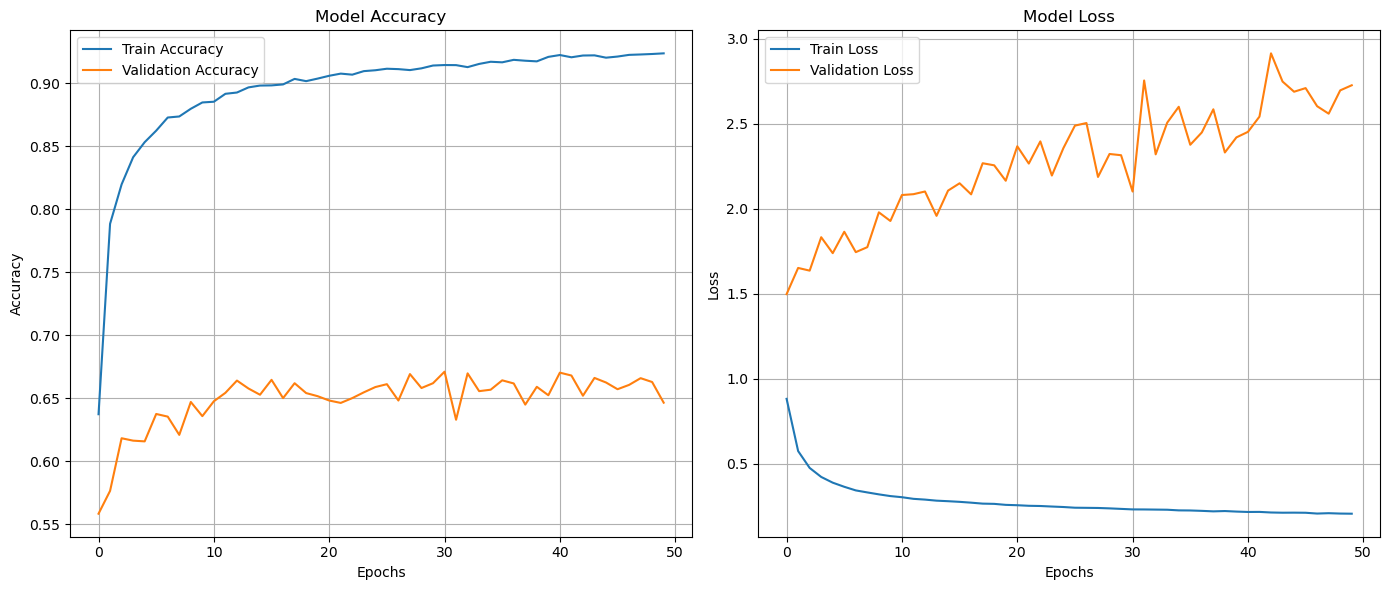

In [214]:
plot_training_history(history_50_clean)

# Normalized Data

### Original Data, 10 Neurons per Layer, Normalized

In [215]:
model_10_original_normalized, history_10_original_normalized, label_encoder_10_original_normalized = train_model(
    train_df=original_train_df,
    valid_df=original_valid_df,
    neurons=10,
    hidden_layers=2,
    normalized=True
)

Epoch 1/50
567/567 [==============================] - 2s 3ms/step - loss: 1.3617 - accuracy: 0.3328 - val_loss: 1.3599 - val_accuracy: 0.2993
Epoch 2/50
567/567 [==============================] - 2s 3ms/step - loss: 1.2562 - accuracy: 0.4168 - val_loss: 1.3856 - val_accuracy: 0.3530
Epoch 3/50
567/567 [==============================] - 2s 3ms/step - loss: 1.1580 - accuracy: 0.4795 - val_loss: 1.3861 - val_accuracy: 0.3782
Epoch 4/50
567/567 [==============================] - 2s 3ms/step - loss: 1.0956 - accuracy: 0.5165 - val_loss: 1.4361 - val_accuracy: 0.4141
Epoch 5/50
567/567 [==============================] - 2s 3ms/step - loss: 1.0476 - accuracy: 0.5451 - val_loss: 1.4397 - val_accuracy: 0.4142
Epoch 6/50
567/567 [==============================] - 2s 3ms/step - loss: 1.0055 - accuracy: 0.5712 - val_loss: 1.5177 - val_accuracy: 0.4366
Epoch 7/50
567/567 [==============================] - 2s 3ms/step - loss: 0.9629 - accuracy: 0.6062 - val_loss: 1.5211 - val_accuracy: 0.4630
Epoch 

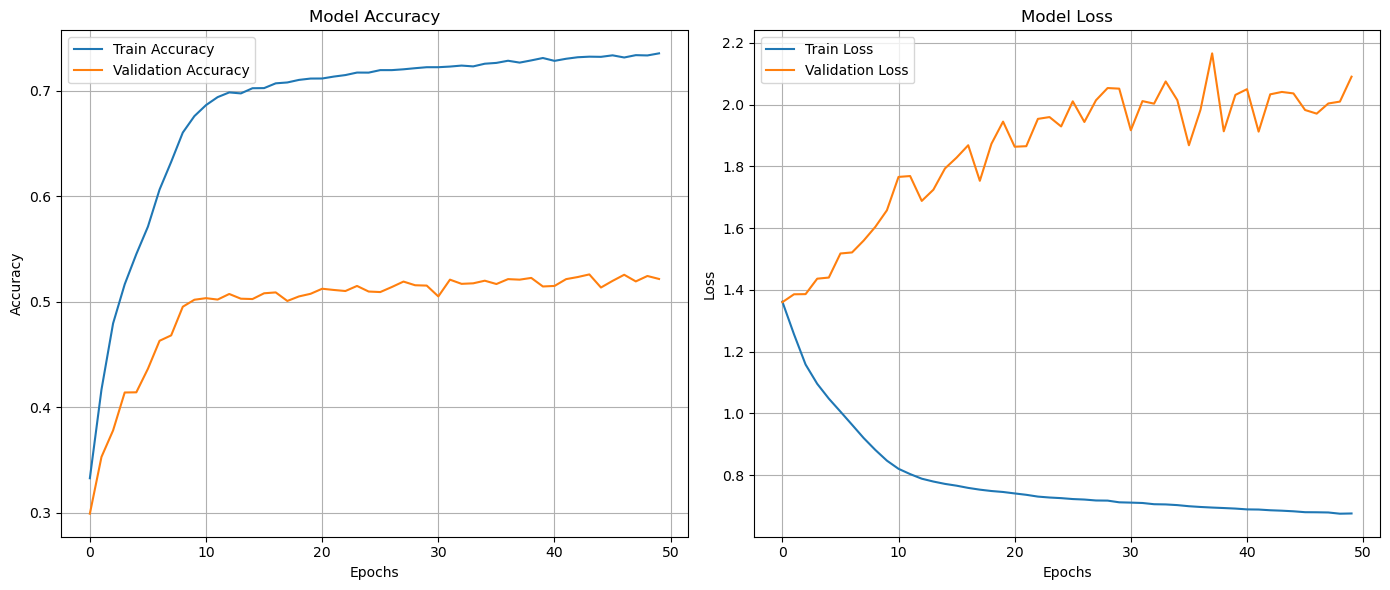

In [216]:
plot_training_history(history_10_original_normalized)

In [218]:
original_10_normalized_test_loss, original_10_normalized_test_accuracy = evaluate_model(
    test_df=original_test_df,
    model=model_10_original_normalized,
    label_encoder=label_encoder_10_original_normalized,
    normalize=True
)

print(f"Test Loss: {original_10_normalized_test_loss:.4f}")
print(f"Test Accuracy: {original_10_normalized_test_accuracy:.4f}")

189/189 [==============================] - 1s 3ms/step - loss: 0.9488 - accuracy: 0.6084
Test Loss: 0.9488
Test Accuracy: 0.6084


189/189 [==============================] - 0s 1ms/step


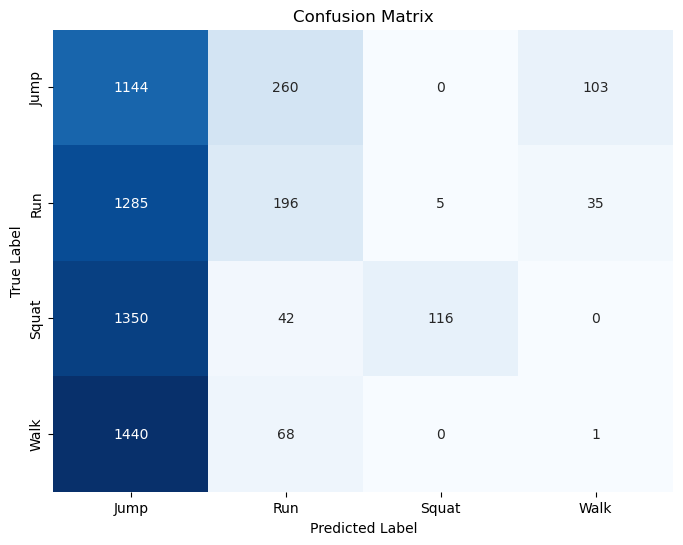

In [176]:
plot_confusion_matrix(
    test_df=original_test_df,
    model=model_10_original_normalized,
    label_encoder=label_encoder_10_original_normalized,
    Normalized=True
)

### Original Data, 50 Neurons per Layer, Normalized

In [221]:
model_50_original_normalized, history_50_original_normalized, label_encoder_50_original_normalized = train_model(
    train_df=original_train_df,
    valid_df=original_valid_df,
    neurons=50,
    hidden_layers=2,
    normalized=True
)

Epoch 1/50
567/567 [==============================] - 3s 4ms/step - loss: 1.2938 - accuracy: 0.3917 - val_loss: 1.3349 - val_accuracy: 0.2787
Epoch 2/50
567/567 [==============================] - 2s 3ms/step - loss: 1.0725 - accuracy: 0.5393 - val_loss: 1.4328 - val_accuracy: 0.4299
Epoch 3/50
567/567 [==============================] - 2s 3ms/step - loss: 0.9128 - accuracy: 0.6549 - val_loss: 1.4280 - val_accuracy: 0.5012
Epoch 4/50
567/567 [==============================] - 2s 3ms/step - loss: 0.8154 - accuracy: 0.6954 - val_loss: 1.5422 - val_accuracy: 0.5241
Epoch 5/50
567/567 [==============================] - 2s 3ms/step - loss: 0.7667 - accuracy: 0.7090 - val_loss: 1.6264 - val_accuracy: 0.5198
Epoch 6/50
567/567 [==============================] - 2s 3ms/step - loss: 0.7334 - accuracy: 0.7193 - val_loss: 1.6072 - val_accuracy: 0.5224
Epoch 7/50
567/567 [==============================] - 1s 3ms/step - loss: 0.7144 - accuracy: 0.7221 - val_loss: 1.7672 - val_accuracy: 0.5219
Epoch 

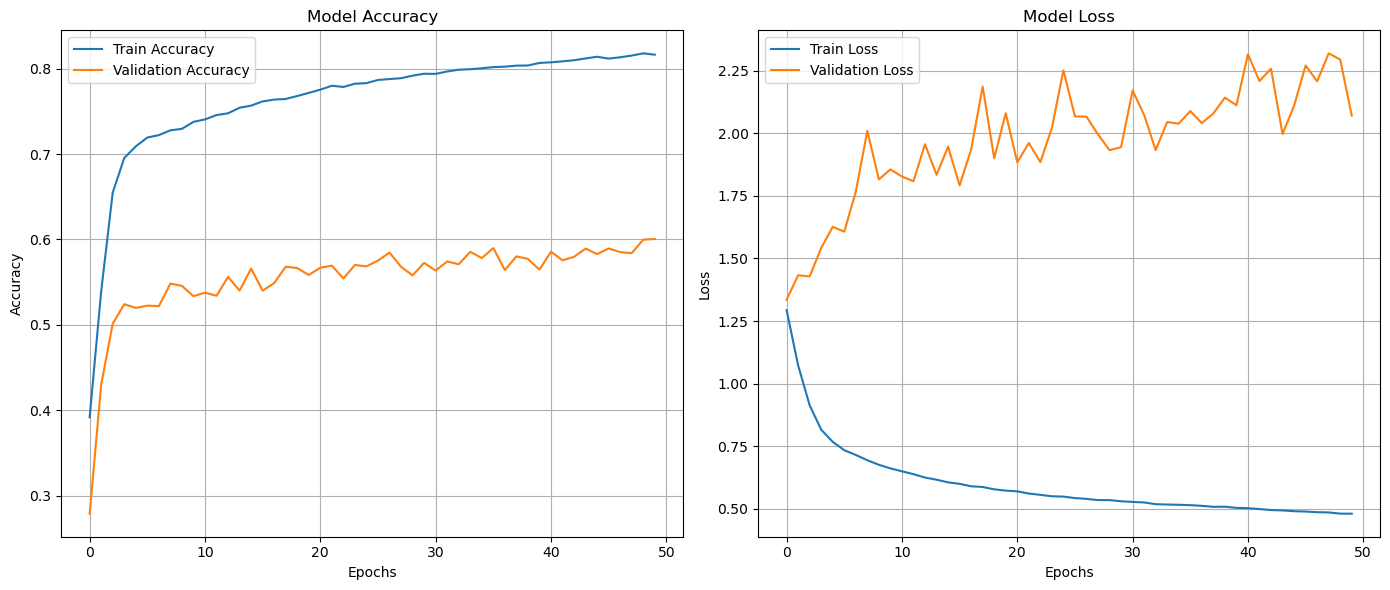

In [222]:
plot_training_history(history_50_original_normalized)

In [223]:
original_50_normalized_test_loss, original_50_normalized_test_accuracy = evaluate_model(
    test_df=original_test_df,
    model=model_50_original_normalized,
    label_encoder=label_encoder_50_original_normalized,
    normalize=True
)

print(f"Test Loss: {original_50_normalized_test_loss:.4f}")
print(f"Test Accuracy: {original_50_normalized_test_accuracy:.4f}")

189/189 [==============================] - 0s 2ms/step - loss: 0.8204 - accuracy: 0.6597
Test Loss: 0.8204
Test Accuracy: 0.6597


189/189 [==============================] - 0s 1ms/step


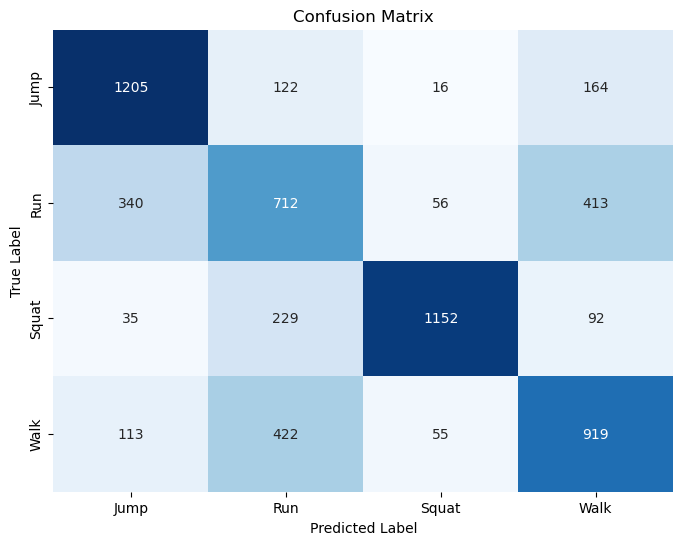

In [224]:
plot_confusion_matrix(
    test_df=original_test_df,
    model=model_50_original_normalized,
    label_encoder=label_encoder_50_original_normalized,
    normalize=True
    
)

### Clean Data, 10 Neurons per Layer, Normalized

In [225]:
model_10_clean_normalized, history_10_clean_normalized, label_encoder_10_clean_normalized = train_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=10,
    hidden_layers=2,
    normalized=True
)

Epoch 1/50
492/492 [==============================] - 2s 3ms/step - loss: 1.3823 - accuracy: 0.2715 - val_loss: 1.3789 - val_accuracy: 0.3178
Epoch 2/50
492/492 [==============================] - 1s 2ms/step - loss: 1.3180 - accuracy: 0.3899 - val_loss: 1.3573 - val_accuracy: 0.2951
Epoch 3/50
492/492 [==============================] - 1s 2ms/step - loss: 1.2368 - accuracy: 0.4102 - val_loss: 1.3595 - val_accuracy: 0.3371
Epoch 4/50
492/492 [==============================] - 1s 2ms/step - loss: 1.1702 - accuracy: 0.4521 - val_loss: 1.3682 - val_accuracy: 0.3235
Epoch 5/50
492/492 [==============================] - 1s 2ms/step - loss: 1.1154 - accuracy: 0.4783 - val_loss: 1.3856 - val_accuracy: 0.3577
Epoch 6/50
492/492 [==============================] - 1s 2ms/step - loss: 1.0772 - accuracy: 0.5215 - val_loss: 1.4064 - val_accuracy: 0.3779
Epoch 7/50
492/492 [==============================] - 1s 2ms/step - loss: 1.0417 - accuracy: 0.5639 - val_loss: 1.4026 - val_accuracy: 0.4444
Epoch 

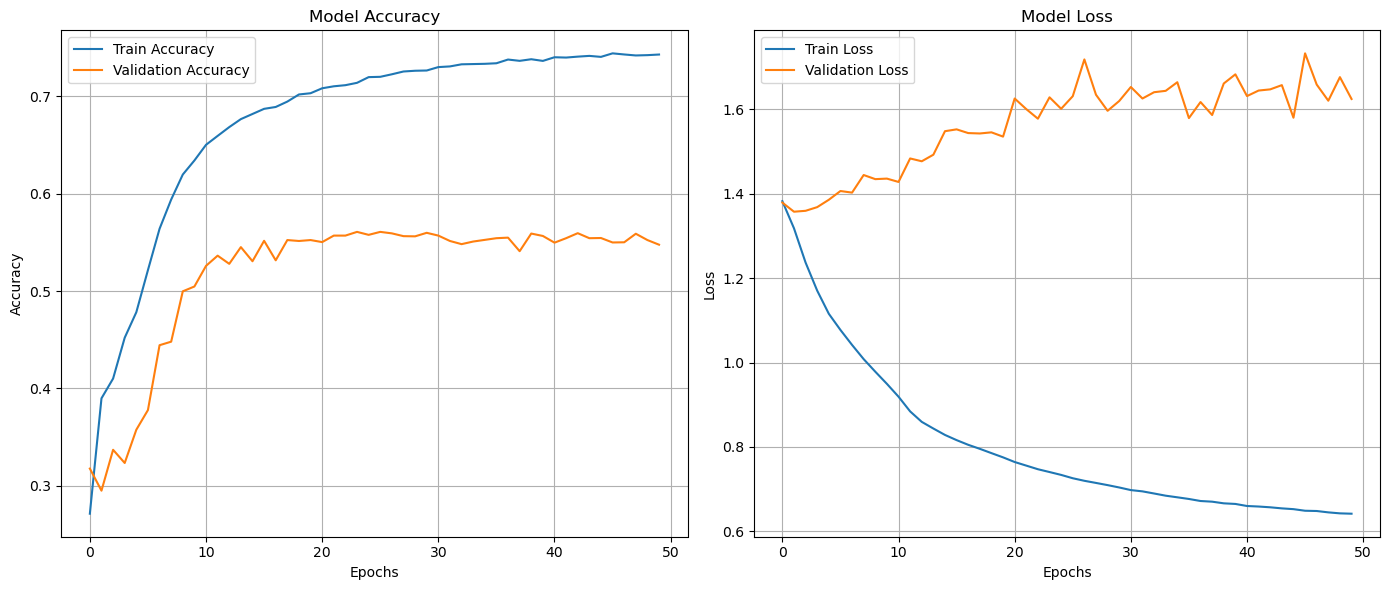

In [226]:
plot_training_history(history_10_clean_normalized)

In [227]:
clean_10_normalized_test_loss, clean_10_normalized_test_accuracy = evaluate_model(
    test_df=clean_test_df,
    model=model_10_clean_normalized,
    label_encoder=label_encoder_10_clean_normalized,
    normalize=True
)

print(f"Test Loss: {clean_10_normalized_test_loss:.4f}")
print(f"Test Accuracy: {clean_10_normalized_test_accuracy:.4f}")

164/164 [==============================] - 0s 2ms/step - loss: 0.8408 - accuracy: 0.6513
Test Loss: 0.8408
Test Accuracy: 0.6513


164/164 [==============================] - 0s 2ms/step


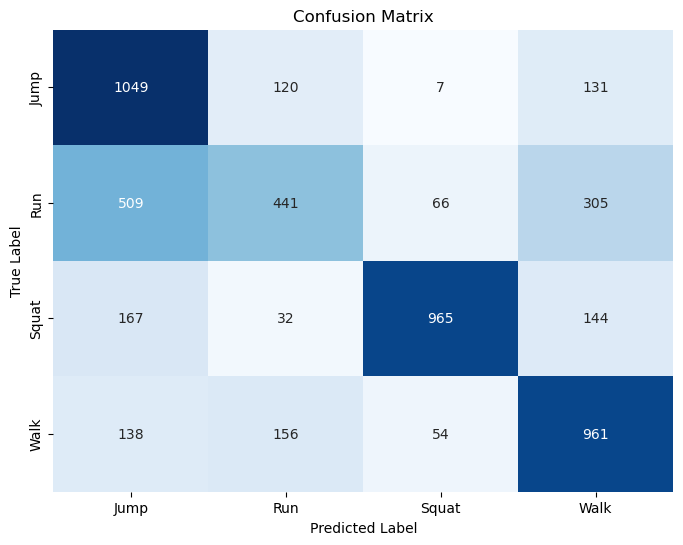

In [228]:
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_10_clean_normalized,
    label_encoder=label_encoder_10_clean_normalized,
    normalize=True
    
)

### Clean Data, 50 Neurons per Layer, Normalized

In [229]:
model_50_clean_normalized, history_50_clean_normalized, label_encoder_50_clean_normalized = train_model(
    train_df=clean_train_df,
    valid_df=clean_valid_df,
    neurons=50,
    hidden_layers=2,
    normalized=True
)

Epoch 1/50
492/492 [==============================] - 2s 3ms/step - loss: 1.2621 - accuracy: 0.4042 - val_loss: 1.2906 - val_accuracy: 0.3178
Epoch 2/50
492/492 [==============================] - 1s 3ms/step - loss: 1.0194 - accuracy: 0.5714 - val_loss: 1.3478 - val_accuracy: 0.4759
Epoch 3/50
492/492 [==============================] - 1s 3ms/step - loss: 0.8764 - accuracy: 0.6666 - val_loss: 1.4637 - val_accuracy: 0.5144
Epoch 4/50
492/492 [==============================] - 1s 3ms/step - loss: 0.8015 - accuracy: 0.6918 - val_loss: 1.4445 - val_accuracy: 0.5203
Epoch 5/50
492/492 [==============================] - 1s 3ms/step - loss: 0.7483 - accuracy: 0.7127 - val_loss: 1.5538 - val_accuracy: 0.5474
Epoch 6/50
492/492 [==============================] - 1s 3ms/step - loss: 0.7159 - accuracy: 0.7192 - val_loss: 1.5869 - val_accuracy: 0.5403
Epoch 7/50
492/492 [==============================] - 1s 2ms/step - loss: 0.6950 - accuracy: 0.7284 - val_loss: 1.7011 - val_accuracy: 0.5344
Epoch 

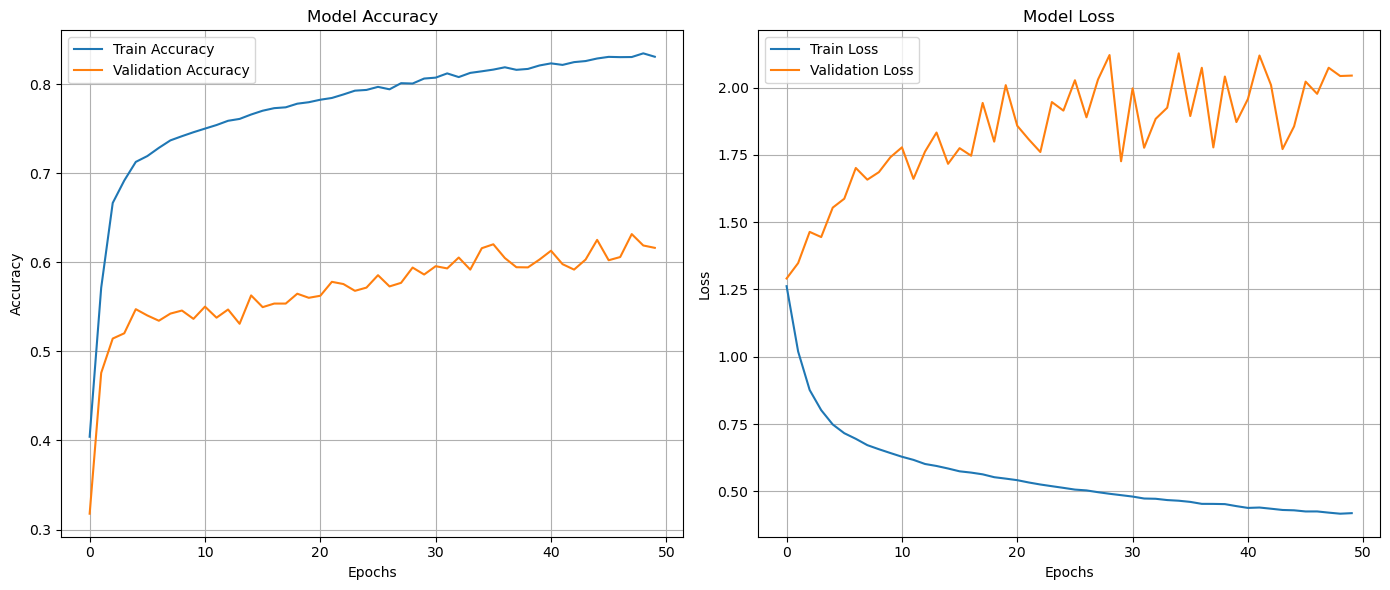

In [230]:
plot_training_history(history_50_clean_normalized)

In [231]:
clean_50_normalized_test_loss, clean_50_normalized_test_accuracy = evaluate_model(
    test_df=clean_test_df,
    model=model_50_clean_normalized,
    label_encoder=label_encoder_50_clean_normalized,
    normalize=True
)

print(f"Test Loss: {clean_50_normalized_test_loss:.4f}")
print(f"Test Accuracy: {clean_50_normalized_test_accuracy:.4f}")

164/164 [==============================] - 0s 2ms/step - loss: 0.6521 - accuracy: 0.7270
Test Loss: 0.6521
Test Accuracy: 0.7270


164/164 [==============================] - 0s 2ms/step


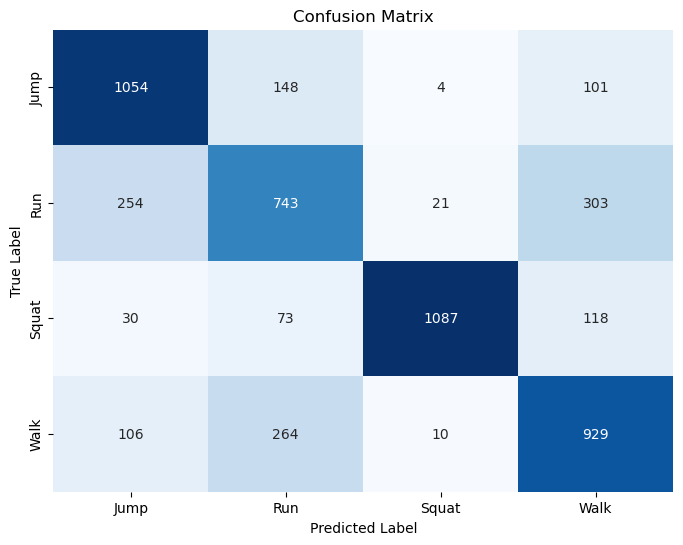

In [232]:
plot_confusion_matrix(
    test_df=clean_test_df,
    model=model_50_clean_normalized,
    label_encoder=label_encoder_50_clean_normalized,
    normalize=True
)

# Questions

### How many epochs do you need?
50 epochs were used for testing at first and was found to be optimal.
The change in the accuracy was very minimal that 50 epochs were enough to be representative of the data.

### Did you normalize the data?
Different models were created for normalized and unnormalized data, for both original and clean data.
There was a difference between having the data unnormalized vs normalized. Unnormalized data was giving a higher accuracy score of ~10-15%.
Clean unnormalized data had the highest training accuracy score with a margin of ~3-5%.

### Why should you normalize the data before input to a neural network?
Normalizing data before input to a neural network helps the network learn more effectively by ensuring faster convergence and balance the contribution of different features, which improves the overall model performance.

### For calculating the confusion matrix should you use evaluate or predict?
Predict. Since predict gives the model's predicted class labels while evaluate returns overall loss and accuracy.

### Calculate the confusion matrix and plot it. Explain the result.

Original_10_unnormalized:

Original_50_unnormalized:

Clean_10_unnormalized:

Clean_50_unnormalized:

Original_10_normalized:

Original_50_normalized:

Clean_10_normalized:

Clean_50_normalized: